In [1]:
from numpy import genfromtxt
import numpy as np
import math

geo_data = genfromtxt('C:\\Users\\bigeardell\\git\\data.gouv.fr\\communes-departement-region.csv', delimiter=',')


In [2]:
# remove header
geo_data = geo_data[1:-1]

communes_dict = {str(int(_id))  : {"lat":lat, "lon": lon } for 
                 _id, _, _,_ ,_,lat, lon,_,_,_,_,_,_,_,_ in geo_data if not  math.isnan(_id) }

import json

with open('C:\\Users\\bigeardell\\git\\data.gouv.fr\\conso-elec-gaz-annuelle-par-secteur-dactivite-agregee-commune.geojson', 'r') as f:
    data = json.load(f)



In [90]:
lon_range =[-5.0, 10.0]
lat_range =[41.0, 51.0]

ctot = {}

for d in data['features']:
    commune_id = d['properties']['code_commune']
    code_epci = d['properties']['code_epci']
    annee = d['properties']['annee']
    
    if annee not in ctot:
        ctot[annee] = []
    
    if commune_id in communes_dict:
        __lat = communes_dict[commune_id]['lat'] 
        __lon = communes_dict[commune_id]['lon']
        if lat_range[0]<__lat<lat_range[1] and lon_range[0]<__lon<lon_range[1]:
            ctot[annee].append((
                code_epci,
                __lat,
                __lon,
                d['properties']['consototale'],
                d['properties']['consoa'],
                d['properties']['consoi'],
                d['properties']['consot'],
                d['properties']['consor'],
            ))


In [92]:
import math

def find_nearest(arr, v):
    return np.absolute(arr - v).argmin() or math.nan

krt = {} 

lon_range =[-5.0, 10.0]
lat_range =[41.0, 51.0]

lon_linspace = np.array(np.linspace(-5.0, 10.0, 100))
lat_linspace = np.array(np.linspace(41.0, 51.0, 100))

for y in ctot:
    for c in ctot[y]:
        if y not in krt:
            krt[y] = {}
        n__lat = find_nearest(lat_linspace, c[1])
        n__lon = find_nearest(lon_linspace, c[2])
        if not math.isnan(n__lat) and not math.isnan(n__lon):
            coords = (round(n__lat), round(n__lon))
            if coords not in krt[y]:
                krt[y][coords] = {'code_epci': [c[0]], 'total': c[3], 'consoa': c[4], 'consoi': c[5], 'consot': c[6], 'consor': c[7]}
            else:
                krt[y][coords]['total'] += c[3]
                krt[y][coords]['consoa'] += c[4]
                krt[y][coords]['consoi'] += c[5]
                krt[y][coords]['consot'] += c[6]
                krt[y][coords]['consor'] += c[7]
                krt[y][coords]['code_epci'].append(c[0])


In [95]:
import matplotlib.pyplot as plt
import math


def gradient(x):
    if math.isnan(x):
        return x
    try:
        return math.log(x)
    except:
        return math.nan

dy = {}    
dy_a = {}    
dy_i = {}    
dy_t = {}    
dy_r = {}    
for y in sorted(krt.keys()):
    d = np.full((100, 100),np.nan)
    d_a = np.full((100, 100),np.nan)
    d_i = np.full((100, 100),np.nan)
    d_t = np.full((100, 100),np.nan)
    d_r = np.full((100, 100),np.nan)
    for la, lo in krt[y].keys():
        d[la][lo] = gradient(krt[y][(la, lo)]['total'])
        d_a[la][lo] = gradient(krt[y][(la, lo)]['consoa'])
        d_i[la][lo] = gradient(krt[y][(la, lo)]['consoi'])
        d_t[la][lo] = gradient(krt[y][(la, lo)]['consot'])
        d_r[la][lo] = gradient(krt[y][(la, lo)]['consor'])
    dy[y]=d    
    dy_a[y]=d_a    
    dy_i[y]=d_i    
    dy_t[y]=d_t    
    dy_r[y]=d_r    



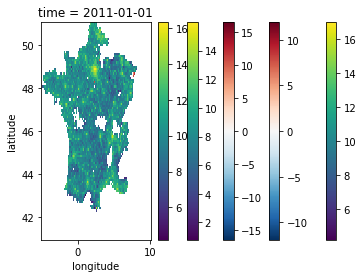

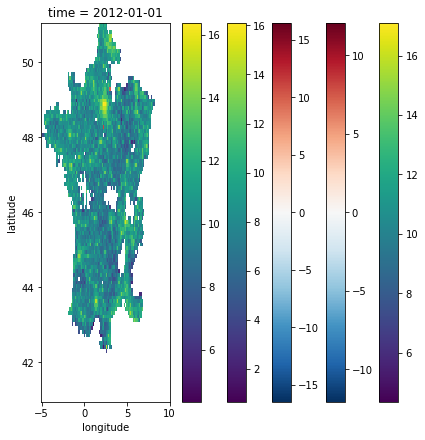

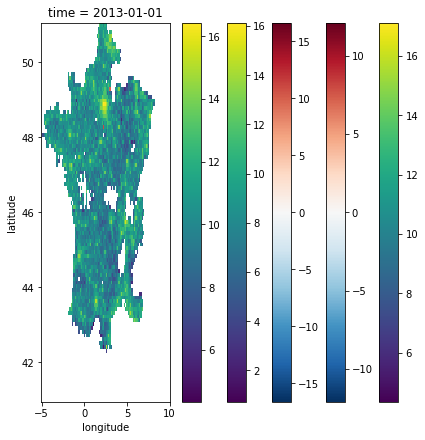

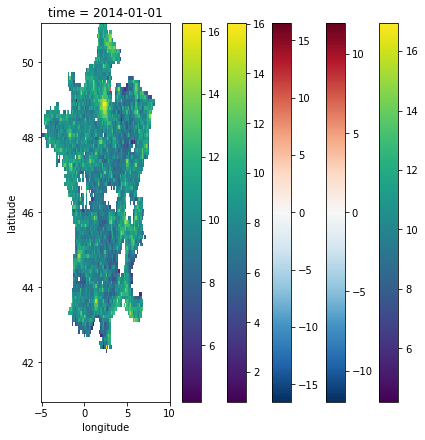

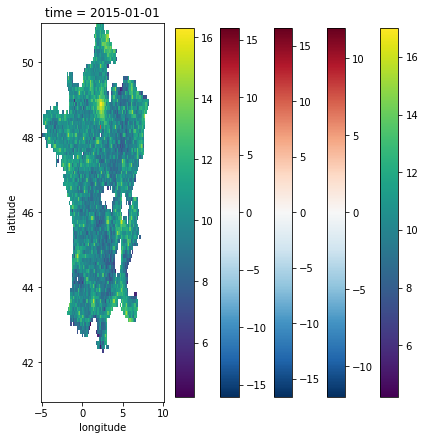

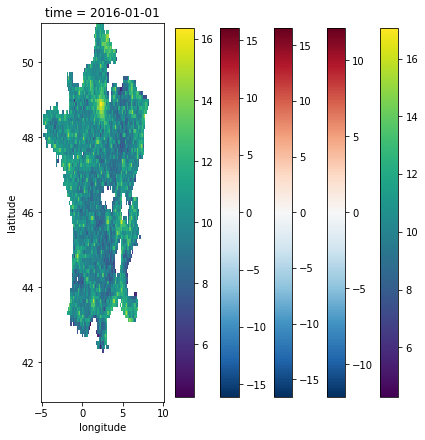

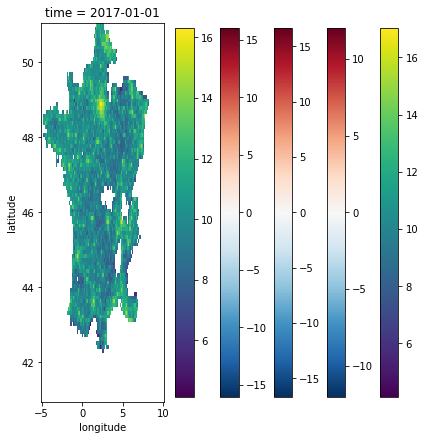

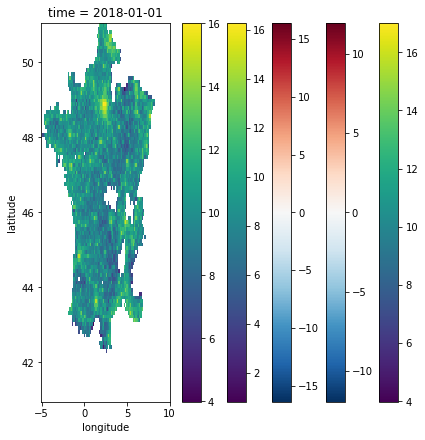

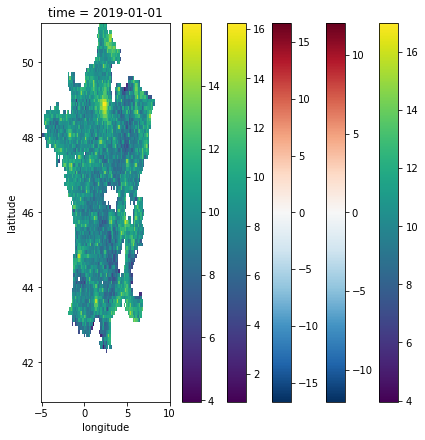

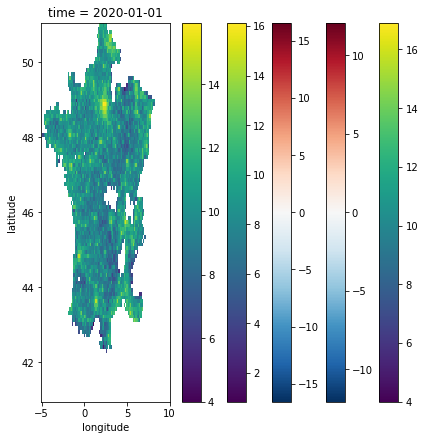

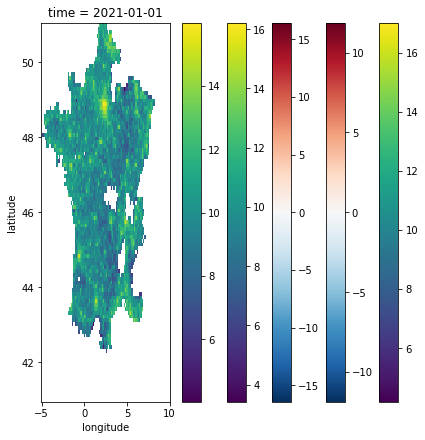

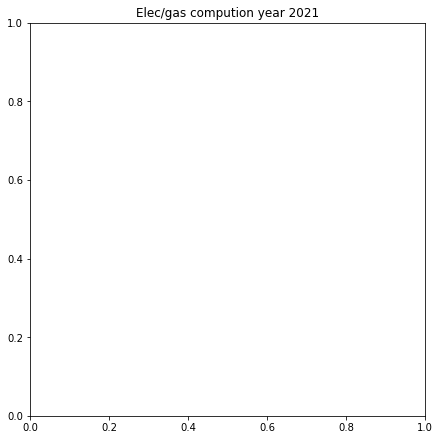

In [96]:
import xarray as xr
import matplotlib.pyplot as plt

for y in dy:
    
    onset_da = xr.DataArray(
                data   = [dy[y]],  
                dims   = ['time', 'latitude', 'longitude'],
                coords = {
                    "time": [pd.to_datetime(f'{y}-01-01')],
                    "latitude": lat_linspace, 
                    "longitude": lon_linspace
                },
                attrs  = {'description': f'Année {y} de consommation gaz/elec'}
            )
    renamed_da = onset_da.rename(f'{y}_consommation_gaz-elec')
    renamed_da.to_dataset().to_netcdf(f'C:\\Users\\bigeardell\\git\\data.gouv.fr\\{y}_consommation_gaz-elec.netcdf');
        
    onset_da.plot()
    
    ######################
    
    onset_da_a = xr.DataArray(
                data   = [dy_a[y]],  
                dims   = ['time', 'latitude', 'longitude'],
                coords = {
                    "time": [pd.to_datetime(f'{y}-01-01')],
                    "latitude": lat_linspace, 
                    "longitude": lon_linspace
                },
                attrs  = {'description': f'Année {y} de consommation gaz/elec agriculture'}
            )
    renamed_da_a = onset_da_a.rename(f'{y}_consommation_gaz-elec_agriculture')
    renamed_da_a.to_dataset().to_netcdf(f'C:\\Users\\bigeardell\\git\\data.gouv.fr\\{y}_consommation_gaz-elec_agriculture.netcdf');
        
    onset_da_a.plot()
    
    ######################
    
    onset_da_i = xr.DataArray(
                data   = [dy_i[y]],  
                dims   = ['time', 'latitude', 'longitude'],
                coords = {
                    "time": [pd.to_datetime(f'{y}-01-01')],
                    "latitude": lat_linspace, 
                    "longitude": lon_linspace
                },
                attrs  = {'description': f'Année {y} de consommation gaz/elec industrie'}
            )
    renamed_da_i = onset_da_a.rename(f'{y}_consommation_gaz-elec_industrie')
    renamed_da_i.to_dataset().to_netcdf(f'C:\\Users\\bigeardell\\git\\data.gouv.fr\\{y}_consommation_gaz-elec_industrie.netcdf');
        
    onset_da_i.plot()

    ######################
    
    onset_da_t = xr.DataArray(
                data   = [dy_t[y]],  
                dims   = ['time', 'latitude', 'longitude'],
                coords = {
                    "time": [pd.to_datetime(f'{y}-01-01')],
                    "latitude": lat_linspace, 
                    "longitude": lon_linspace
                },
                attrs  = {'description': f'Année {y} de consommation gaz/elec tertiaire'}
            )
    renamed_da_t = onset_da_a.rename(f'{y}_consommation_gaz-elec_tertiaire')
    renamed_da_t.to_dataset().to_netcdf(f'C:\\Users\\bigeardell\\git\\data.gouv.fr\\{y}_consommation_gaz-elec_tertiaire.netcdf');
        
    onset_da_t.plot()

    ######################
    
    onset_da_r = xr.DataArray(
                data   = [dy_r[y]],  
                dims   = ['time', 'latitude', 'longitude'],
                coords = {
                    "time": [pd.to_datetime(f'{y}-01-01')],
                    "latitude": lat_linspace, 
                    "longitude": lon_linspace
                },
                attrs  = {'description': f'Année {y} de consommation gaz/elec residentiel'}
            )
    renamed_da_r = onset_da_a.rename(f'{y}_consommation_gaz-elec_residentiel')
    renamed_da_r.to_dataset().to_netcdf(f'C:\\Users\\bigeardell\\git\\data.gouv.fr\\{y}_consommation_gaz-elec_residentiel.netcdf');
        
    onset_da_r.plot()

    # plot
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))
    ax.set_title(f'Elec/gas compution year {y}')


